In this notebook, we'll analyze the mitotic activity of cases divided into two hypothetical distributions:
mitotic-cold (low activity) and mitotic-hot (high activity).
By observing a mixture of these cases, we'll attempt to use a Gaussian Mixture Model (GMM) to discover the two underlying distributions.
We'll also determine a threshold, or cut-off point, between the two groups based on their distribution overlap.

# 1. Real-World Simulated Data (Noisy Mixture Data)
In this section, we create synthetic data for mitotic-cold and mitotic-hot groups. To make it more representative of real-world measurements, we introduce noise and quantization. By rounding the data and adding small random noise, we simulate data that resembles practical measurements, where exact values might be influenced by noise or measurement limitations. The result is stored in mixture_data_noisy, representing mitotic activity data from both subgroups.

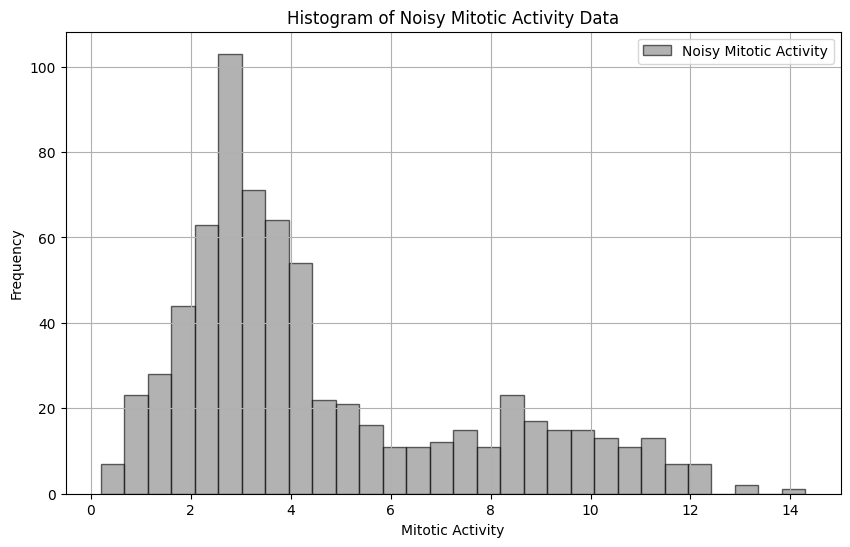

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Set random seed for reproducibility
np.random.seed(0)

# 1. Real-World Simulated Data (Noisy Mixture Data)
# ===========================================================
# Parameters for mitotic-cold and mitotic-hot distributions
mu_cold, sigma_cold = 3, 1  # mitotic-cold: mean 1, stddev 1
mu_hot, sigma_hot = 9, 2    # mitotic-hot: mean 6, stddev 2

# Generate sample data from both distributions
data_cold = np.random.normal(mu_cold, sigma_cold, 500)
data_hot = np.random.normal(mu_hot, sigma_hot, 200)

# Combine and quantize data to simulate a noisy real-world measurement
mixture_data_noisy = np.concatenate([data_cold, data_hot])
mixture_data_noisy = np.round(mixture_data_noisy + np.random.normal(0, 0.5, mixture_data_noisy.shape), 1).reshape(-1, 1)

# Visualize the noisy data with a histogram
plt.figure(figsize=(10, 6))
plt.hist(mixture_data_noisy, bins=30, color='gray', edgecolor='black', alpha=0.6, label='Noisy Mitotic Activity')
plt.xlabel('Mitotic Activity')
plt.ylabel('Frequency')
plt.title('Histogram of Noisy Mitotic Activity Data')
plt.legend()
plt.grid(True)
plt.show()



Above, we visualize the noisy mixture data using a histogram, which provides a clear view of the data distribution. This histogram illustrates how the real-world-like data looks as a mixture of mitotic-cold and mitotic-hot groups. The histogram helps us see the data's combined spread and hints at the presence of multiple underlying distributions. So, we will work with this and imagine that have no direct access to the original gaussian parameters that have been used to make this. Based on this plot, what would you think to be a good threshold (cutt-off) on the x-axis to separate between the groups with low and high mitotic activity?


# 2. Using GMM to Estimate Underlying Distributions
In analyzing mitotic activity, we aim to identify two distinct subgroups within the data: mitotic-cold (lower activity) and mitotic-hot (higher activity) groups. Given that biological processes often display variability that can be well-represented by normal distributions, it’s reasonable to assume that each subgroup has a Gaussian (normal) distribution. This assumption means each group has a characteristic range of mitotic activity levels, described by a unique mean and standard deviation, reflecting their typical and expected variations.

To uncover these underlying distributions in the noisy, combined data, we employ the Gaussian Mixture Model (GMM). The GMM is a probabilistic model that assumes the observed data is a combination of multiple Gaussian distributions. By fitting a GMM with two components, we can estimate the parameters (means and variances) of these two assumed normal distributions, which correspond to the mitotic-cold and mitotic-hot groups. This model allows us to better understand each subgroup’s typical mitotic activity and will also help us define a cut-off point between the groups based on their overlap in distribution.

In [5]:
# 2. Using GMM to Estimate Underlying Distributions
# ===========================================================
# Fit GMM with two components to the noisy data
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(mixture_data_noisy)

# Extract the estimated means and variances of the two components
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
mean1, mean2 = np.sort(means)
var1, var2 = variances[np.argsort(means)]

print("Estimated Means:", mean1, mean2)
print("Estimated Variances:", var1, var2)


Estimated Means: 3.0298340419824914 8.844493531289952
Estimated Variances: 1.3075920967396917 3.820217047561751


In the following visualization, we overlay the estimated mixture model (calculated from the GMM) on top of the histogram of the noisy data. This provides a side-by-side view of the real-world-like data and the underlying distribution estimated by the GMM. The overlay allows us to compare the actual noisy data with the model's smooth estimation.

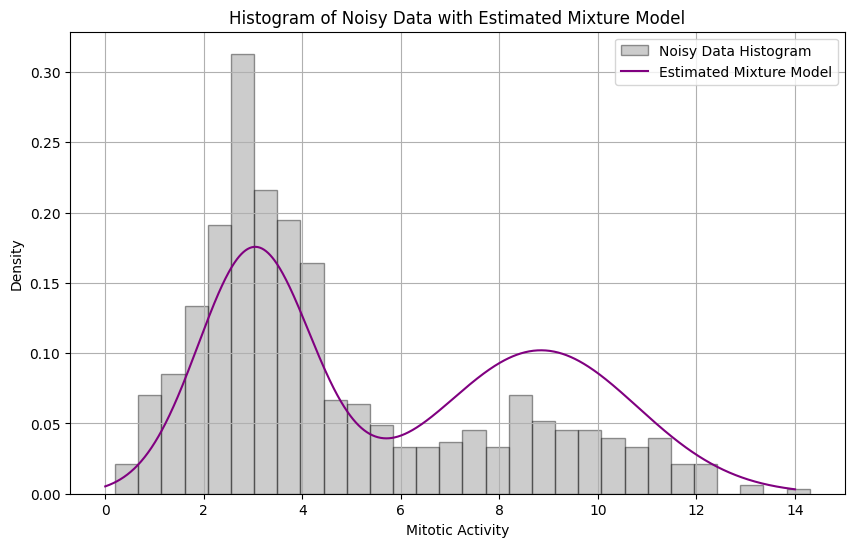

In [8]:
# Visualization: Noisy Data Histogram with Estimated Mixture Model
# ===========================================================
# Plot the histogram of the noisy data and overlay the estimated mixture distribution

x = np.linspace(0, 14, 1000) #just defining the range in which we want to sample from estimated normal distributions
pdf_cold_estimated = norm.pdf(x, mean1, np.sqrt(var1))
pdf_hot_estimated = norm.pdf(x, mean2, np.sqrt(var2))
mixture_pdf_estimated = 0.5 * pdf_cold_estimated + 0.5 * pdf_hot_estimated

plt.figure(figsize=(10, 6))
plt.hist(mixture_data_noisy, bins=30, color='gray', edgecolor='black', alpha=0.4, density=True, label='Noisy Data Histogram') # visualizing noisy data, like before
plt.plot(x, mixture_pdf_estimated, label='Estimated Mixture Model', color='purple')
plt.xlabel('Mitotic Activity')
plt.ylabel('Density')
plt.title('Histogram of Noisy Data with Estimated Mixture Model')
plt.legend()
plt.grid(True)
plt.show()

# 3. Finding the Intersection (Cut-Off Point)
The intersection point between the two Gaussian distributions serves as an effective threshold, or cut-off, to distinguish between the mitotic-cold and mitotic-hot subgroups. At this point, the probability densities of the two distributions are equal, meaning a case at this mitotic activity level could reasonably belong to either group. By selecting this intersection as the cut-off, we ensure that values below it are more likely associated with the mitotic-cold group, and values above it are more likely to belong to the mitotic-hot group.

## Mathematical Derivation of the Intersection Formula
> FEEL FREE TO INGNORE THIS PART

To find this intersection, We start by setting the probability density functions (PDFs) of the two distributions equal to each other:

$$f_1(x) = f_2(x)$$

Given two normal distributions $ N(\mu_1, \sigma_1^2) $ and $ N(\mu_2, \sigma_2^2) $, the PDFs are:

$$f_1(x) = \frac{1}{\sigma_1 \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu_1)^2}{2 \sigma_1^2}\right)$$

$$f_2(x) = \frac{1}{\sigma_2 \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu_2)^2}{2 \sigma_2^2}\right)$$

Setting $ f_1(x) = f_2(x) $ and simplifying, we obtain an equation in the form of a quadratic:

$$ a x^2 + b x + c = 0 $$

where:
- $$ a = \frac{1}{2 \sigma_1^2} - \frac{1}{2 \sigma_2^2} $$
- $$ b = \frac{\mu_2}{\sigma_2^2} - \frac{\mu_1}{\sigma_1^2} $$
- $$ c = \frac{\mu_1^2}{2 \sigma_1^2} - \frac{\mu_2^2}{2 \sigma_2^2} - \ln\left(\frac{\sigma_2}{\sigma_1}\right) $$

​Using the quadratic formula, we solve for $ x $:

$$ x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} $$

This root represents the point where the probability densities of the two groups are equal, providing a natural separation threshold between mitotic-cold and mitotic-hot cases.

In [9]:

# 3. Finding the Intersection (Cut-Off Point)
# ===========================================================
# Using the estimated parameters to calculate the intersection point (where two distributions touch)
# define a reusable function that finds intersection of two normal distributions given their means and standard-deviations
def find_intersection(mu1, sigma1, mu2, sigma2):
    # Calculate coefficients for the quadratic equation
    a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
    b = mu2/(sigma2**2) - mu1/(sigma1**2)
    c = mu1**2 / (2*sigma1**2) - mu2**2 / (2*sigma2**2) - np.log(sigma2/sigma1)
    
    # Solve for the intersection point
    roots = np.roots([a, b, c])
    intersection_point = roots[np.logical_and(roots > mu1, roots < mu2)][0]
    return intersection_point

# Find the intersection point based on estimated GMM parameters
intersection_point = find_intersection(mean1, np.sqrt(var1), mean2, np.sqrt(var2))
print("Intersection Point (Cut-Off):", intersection_point)



Intersection Point (Cut-Off): 5.378151645105218


This final plot shows the estimated Gaussian components (mitotic-cold and mitotic-hot), their combined mixture distribution, and the cut-off point for separation. Each Gaussian component is displayed as a dashed line, while the mixture model is shown as a solid line. The red dashed line marks the cut-off, representing the threshold where we can separate mitotic-cold and mitotic-hot cases. This visualization highlights how the GMM’s parameters and the intersection provide an effective way to distinguish the two groups.

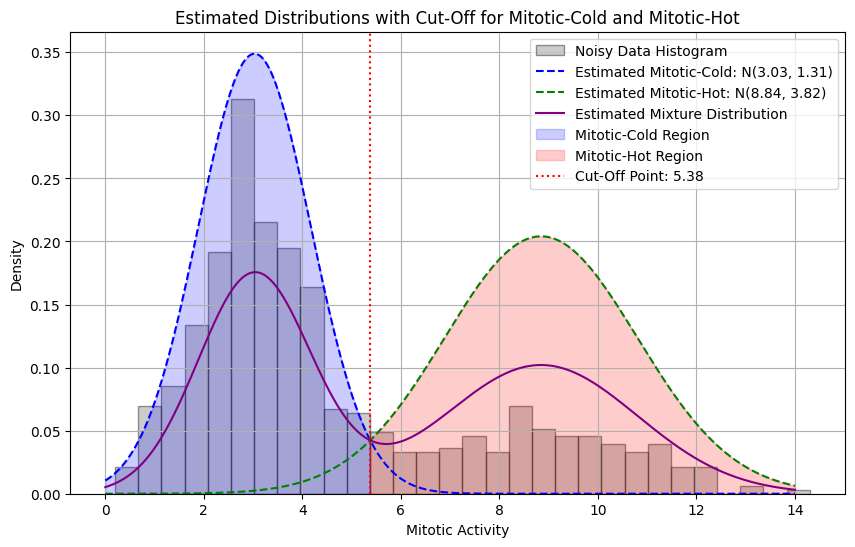

In [13]:
# Final Visualization: Estimated Gaussian Components and Cut-Off
# ===========================================================
# Plot the main histogram, then shade the mitotic-cold and mitotic-hot regions separately

plt.figure(figsize=(10, 6))

# Main histogram for noisy data
plt.hist(mixture_data_noisy, bins=30, color='gray', edgecolor='black', alpha=0.4, density=True, label='Noisy Data Histogram')

# Plot the estimated Gaussian components and mixture distribution
plt.plot(x, pdf_cold_estimated, label=f'Estimated Mitotic-Cold: N({mean1:.2f}, {var1:.2f})', color='blue', linestyle='--')
plt.plot(x, pdf_hot_estimated, label=f'Estimated Mitotic-Hot: N({mean2:.2f}, {var2:.2f})', color='green', linestyle='--')
plt.plot(x, mixture_pdf_estimated, label='Estimated Mixture Distribution', color='purple')

# Shade regions for mitotic-cold (left side) and mitotic-hot (right side)
plt.fill_between(x, 0, pdf_cold_estimated, where=(x < intersection_point), color='blue', alpha=0.2, label='Mitotic-Cold Region')
plt.fill_between(x, 0, pdf_hot_estimated, where=(x >= intersection_point), color='red', alpha=0.2, label='Mitotic-Hot Region')

# Add a vertical line for the cut-off point
plt.axvline(intersection_point, color='red', linestyle=':', label=f'Cut-Off Point: {intersection_point:.2f}')

# Labels, title, and legend
plt.xlabel('Mitotic Activity')
plt.ylabel('Density')
plt.title('Estimated Distributions with Cut-Off for Mitotic-Cold and Mitotic-Hot')
plt.legend()
plt.grid(True)
plt.show()
